In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install yfinance
!pip install --upgrade pandas

In [1]:
import numpy as np
# hỗ trợ cho việc tính toán các mảng nhiều chiều
import pandas as pd
# thao tác và phân tích dữ liệu
import yfinance as yf
import matplotlib.pyplot as plt
# vẽ biểu đồ, đồ thị
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
# hàm đưa dữ liệu về giá trị (0,1)
from keras.preprocessing.sequence import TimeseriesGenerator
# Gộp dữ liệu vào chuyển thành dữ liệu time series
from keras.models import Sequential
# khởi tạo mạng neurol
from keras.layers import Dense
# một lớp để chuyển dữ liệu từ lớp input vào model ????
from keras.layers import LSTM
# mô hình LSTM 
from keras.layers import Dropout
# giúp bỏ bớt các node, giúp lọc lại những node có thông tin cần thiết 
from tensorflow import keras
# from datetime import datatime
plt.style.use("fivethirtyeight")
# style của thư viện mathplotlib
import warnings
warnings.filterwarnings("ignore")
# Những thư viện cần dùng

In [2]:
#@title Chương trình dự đoán cổ phiếu bằng thuật toán LSTM
Macophieu = "AAPL" #@param ["GOOG", "AMZN", "FB","AAPL","TSLA"]

prop = 'Close'  #@param ["Open", "High", "Low","Close","Volume"]

companyName = 'Apple' #@param["Google", "Amazon", "Facebook", "Apple", "Tesla"]

# Chọn cổ phiếu cần dự doán
tickerData = yf.Ticker(Macophieu) 
#@title Date fields
start ='2010-11-10'#@param {type:"date"}
end ='2021-12-17'#@param {type:"date"}
tickerDf = tickerData.history(period='1d', start=start, end=end)
#lấy giá trị từ ngày đến những ngày trước đó
data = tickerDf
data.reset_index(inplace=True)
# đánh số thứ tự lại cho data thay cho cột ngày
print(data)

           Date        Open        High  ...     Volume  Dividends  Stock Splits
0    2010-11-10    9.695574    9.760795  ...  384227200        0.0           0.0
1    2010-11-11    9.645357    9.749466  ...  361284000        0.0           0.0
2    2010-11-12    9.675977    9.691287  ...  795846800        0.0           0.0
3    2010-11-15    9.445104    9.508793  ...  403606000        0.0           0.0
4    2010-11-16    9.361198    9.418763  ...  657650000        0.0           0.0
...         ...         ...         ...  ...        ...        ...           ...
2790 2021-12-10  175.210007  179.630005  ...  115228100        0.0           0.0
2791 2021-12-13  181.119995  182.130005  ...  153237000        0.0           0.0
2792 2021-12-14  175.250000  177.740005  ...  139380400        0.0           0.0
2793 2021-12-15  175.110001  179.500000  ...  131063300        0.0           0.0
2794 2021-12-16  179.279999  181.139999  ...  150185800        0.0           0.0

[2795 rows x 8 columns]


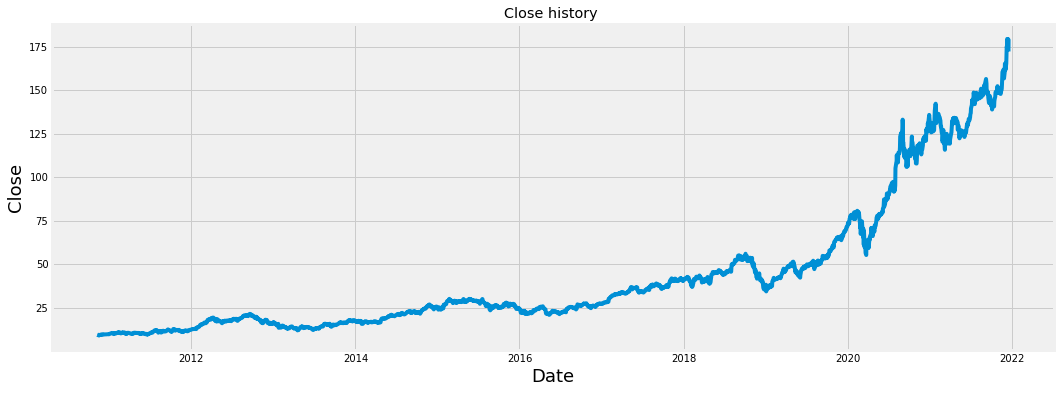

In [4]:
plt.figure(figsize = (16,6))
plt.plot(data['Date'],data[prop])
plt.title( prop + " history ")
plt.xlabel('Date', fontsize = 18)
plt.ylabel(f'{prop}', fontsize = 18)
plt.show()

In [ ]:
data_end = int(np.floor(0.8*(data.shape[0])))
# lấy cái mốc là data_end theo tử lệ 2:8
train = data[0:data_end][prop] 
# lấy 80% là giá mỏ cho tập train
test = data[data_end:][prop]
# lấy 20% data là giá mở cho tập test
date_test = data[data_end:]['Date']
# lấy 20% là ngày trùng vs tập test 

In [ ]:
train = train.values.reshape(-1)
test = test.values.reshape(-1)
date_test = date_test.values.reshape(-1)
# chuyển ma trận sao cho phù hợp với đầu vào của keras

In [ ]:
def get_data(train,test,time_step,num_predict,date):
  x_train= list()
  y_train = list()
  x_test = list()
  y_test = list()
  date_test= list()
# khởi tọa các list trổng để lưu data test, train
# time_step = 30 số lượng ngày đưa vào, num_predict = 1 số lượng đầu ra
  for i in range(0,len(train) - time_step - num_predict):
    x_train.append(train[i:i+time_step])
    y_train.append(train[i+time_step:i+time_step+num_predict])
# y(dự đoán của 30 đầu vào) = f(x(giá open 30 ngày)w(giá trị cần cải thiện trong model) + bias(giá trị cần cải thiện trong model))
# đưa vào giá của 30 ngày tương ứng với 1 state và đầu ra y mũ cho 1 node tưởng tự n data còn lại
# đưa giá trị vào mảng x_train(giá mở của 80% tập data ngày trước để đưa vào cho máy học), y_train(giá mở của ngày thứ 31) 
  for i in range(0, len(test) - time_step - num_predict):
    x_test.append(test[i:i+time_step])
    y_test.append(test[i+time_step:i+time_step+num_predict])
    date_test.append(date[i+time_step:i+time_step+num_predict])
# Xử lý đưa data vào list tương tự như tập train
  return np.asarray(x_train), np.asarray(y_train), np.asarray(x_test), np.asarray(y_test), np.asarray(date_test)
  # chuyển dữ liệu thành dạng mảng

In [ ]:
# gọi hàm dựa data vào mảng train test time_step num_predict, date_test
x_train, y_train, x_test, y_test, date_test = get_data(train,test,30,1, date_test)

# chuyển về dạng ma trận đưa vào minmaxscaler()
x_train = x_train.reshape(-1,30)
x_test = x_test.reshape(-1,30)

# dua ve 0->1 cho tap train
scaler = MinMaxScaler()

# gọi hàm scaler để nén hoặc giải nén data về khoảng (0,1) để máy hiểu góp phần tăng tốc độ máy học
# fit_transform nén data lại cho model cho 4 ma trận x, y_train x,y test
x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test)

In [ ]:
# chuyển về dạng ma trận đưa vào keras() thêm một chiều thứ 3 để có bias => để thành ma trận 3D cho phù hợp với bài toán

# Reshape lai cho x_train
x_train = x_train.reshape(-1,30,1)
y_train = y_train.reshape(-1,1)

#reshape lai cho test
x_test = x_test.reshape(-1,30,1)
y_test = y_test.reshape(-1,1)
date_test = date_test.reshape(-1,1)

In [ ]:
# 1 lớp là giá của 30 ngày (n_input)
# n_feature số lượng cột ở đây là giá mở
# return_sequences trả về chuỗi 

n_input = 30
n_features = 1

# Khởi tạo mạng neurol
model = Sequential()
model.add(LSTM(units = 50, input_shape=(n_input, n_features), return_sequences=True))
# trả về dạng chuỗi để đưa vào layer tiếp theo
# true thì nó trả về chuỗi các hidden state false thì trả về output
model.add(Dropout(0.3))
# lớp thứ hai
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.3))
# lớp thứ ba
model.add(LSTM(units = 50))
model.add(Dropout(0.3))
# đưa về lớp cuối cùng 1 node
model.add(Dense(1))
# đưa vào xác định hàm lỗi(loss function) 'mse' và hàm tối ưu(vd gradient) 'adam' 
model.compile(optimizer ='adam', loss ='mse')

In [ ]:
%cd /content/drive/MyDrive/co phieu
# fit đưa tất cả vào model
model.fit(x_train, y_train, epochs=200, validation_split=0.2, verbose=1, batch_size=30)
model.save(f'{Macophieu}_{prop}.h5')

In [ ]:
%cd /content/drive/MyDrive/co phieu
# Test model vừa train
model = keras.models.load_model(f'{Macophieu}_{prop}.h5')
# load model
test_output = model.predict(x_test)
# lấy tập x_test cho vào model ra test_output là data dự đoán

# giải nén dữ liệu từ (0,1) ra giá thực tế
test_1 = scaler.inverse_transform(test_output)
test_2 =scaler.inverse_transform(y_test)


/content/drive/MyDrive/co phieu


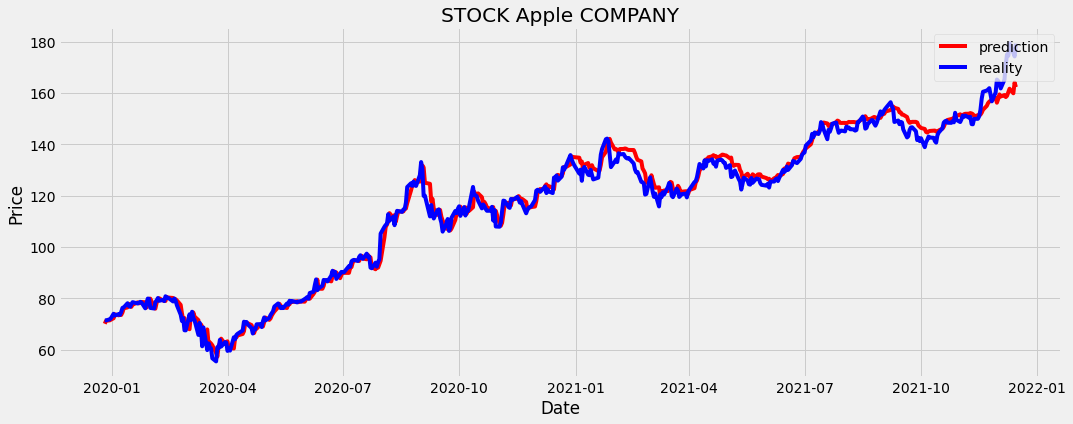

In [ ]:
plt.figure(figsize=(16,6))
# đưa lên biểu đồ 
plt.plot(date_test[30:], test_1[30:], color='r')
plt.plot(date_test[30:], test_2[30:], color='b')
plt.title(f"STOCK {companyName} COMPANY")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(('prediction', 'reality'),loc='upper right')
plt.show()

In [ ]:
test_output = model.predict(x_test) 
print("Evaluate on test data") 
results = model.evaluate(x_test, y_test, batch_size=128) 
print('\n')
print("test loss, test acc:", results,1-results)
print('Giá dư doán của ngày hôm qua: '+str(test_1[-1:]))

Evaluate on test data
5/5 [==============================] - 1s 11ms/step - loss: 7.4576e-04


test loss, test acc: 0.0007457574247382581 0.9992542425752617
Giá dư doán của ngày hôm qua: [[162.3875]]
